In [1]:
from pandas import *
import pandas
print pandas.__version__
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from geopy.geocoders import Nominatim

import re

geolocator = Nominatim()

%matplotlib inline
matplotlib.style.use('fivethirtyeight')




0.19.2


## Load datas


In [2]:
weather = read_csv('201402_babs_open_data/201402_weather_data.csv',index_col=0,parse_dates=True)


In [3]:
#status = read_csv('201402_babs_open_data/201402_status_data.csv',index_col=0,parse_dates=True)


In [4]:
stations = read_csv('201402_babs_open_data/201402_station_data.csv',index_col=0,parse_dates=True)


In [177]:
trips = read_csv('201402_babs_open_data/201402_trip_data.csv',index_col=0,parse_dates=True)

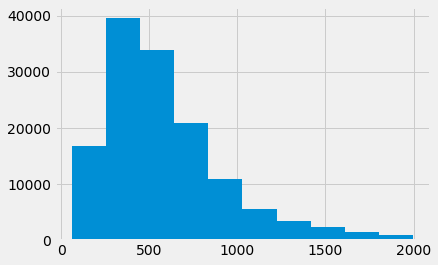

In [178]:
trips.Duration[trips.Duration<2000].hist()


In [179]:
print "normal trips", trips.Duration[trips.Duration<2000][trips.Duration>300].count()
print "short trips", trips.Duration[trips.Duration<300].count()
print "long trips", trips.Duration[trips.Duration>100000].count()
print "all trips", trips.Duration.count()


normal trips 109540
short trips 25921
long trips 60
all trips 144015


In [180]:
# take the trips that are longer than 5 minutes
trips = trips[trips.Duration>300]

In [181]:
trips_start = trips.loc[:,['Start Date','Start Terminal','Subscription Type']]
trips_start.loc[:,'Start Date'] = trips_start.loc[:,'Start Date'].apply(to_datetime)
trips_start.loc[:,"Date"] = trips_start.loc[:,'Start Date'].dt.date.apply(to_datetime)
trips_start = trips_start.rename(columns={"Start Terminal": "st_id", "Start Date": "date_time", "Subscription Type": "subsc_type"})


In [182]:
# Need internet connection to work!!
# Transfer zip codes to coordinates.
# Instead of apply function to all, it is faster
# to apply to unique values of zip the merge
zcit = Series(weather.zip.unique())

def zip2coor(x):
    loca = geolocator.geocode('CA:'+str(x),timeout=20) 
    # as we are in California added CA:. otherwise work not in all cases
    return Series({'lat':loca.latitude,'long':loca.longitude, 'zip':int(x)})

zipcoor = zcit.apply(zip2coor)
zipcoor.zip = zipcoor.zip.apply(int) #make zip int instead of float.
b = weather.reset_index().merge(zipcoor, on='zip').set_index('Date') #add coordinates to weather

In [183]:
weather_small = b.loc[:,['Max_Temperature_F','Events','lat','long']]


In [184]:
weather_small = weather_small.rename(columns={"lat": "lat_cit", "long": "long_cit"})

In [185]:
# the function distance do not use Internet
from geopy.distance import vincenty

coorstat = stations.loc[:,['lat','long']]
stations.loc[:,'st_id'] =stations.index

def get_cit_coor(x):
    c_stat = (x[0],x[1])
    mdist=1000
    for i in xrange(zipcoor.size):
        c_city = (zipcoor.lat[0],zipcoor.long[0])
        dist = vincenty(c_city, c_stat).kilometers
        if dist < mdist:
            mdist = dist
            coor=c_city
    return Series({'lat':x[0],'long':x[1],'lat_cit':coor[0],'long_cit':coor[1]})

a = stations.ix[:,'lat':'long'].apply(get_cit_coor,axis=1)
a = stations.merge(a,on=['lat','long'])


In [186]:
stations_small=a.loc[:,['lat','long','lat_cit','long_cit','landmark','st_id']]


In [187]:
weather_small.ix[:,'Date']=weather_small.index


In [188]:
result_small = trips_start.merge(stations_small, on='st_id')
result_small = result_small.merge(weather_small, on=['Date','lat_cit','long_cit'])
result_small.Events[result_small.Events=='rain'] = 'Rain'
result_small.Events[isnull(result_small.Events)]='Sun'
def f(x):
    return (x  - 32.)/1.8
result_small['day_of_week'] = result_small['Date'].dt.weekday_name
result_small.Max_Temperature_F = result_small.Max_Temperature_F.apply(f)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


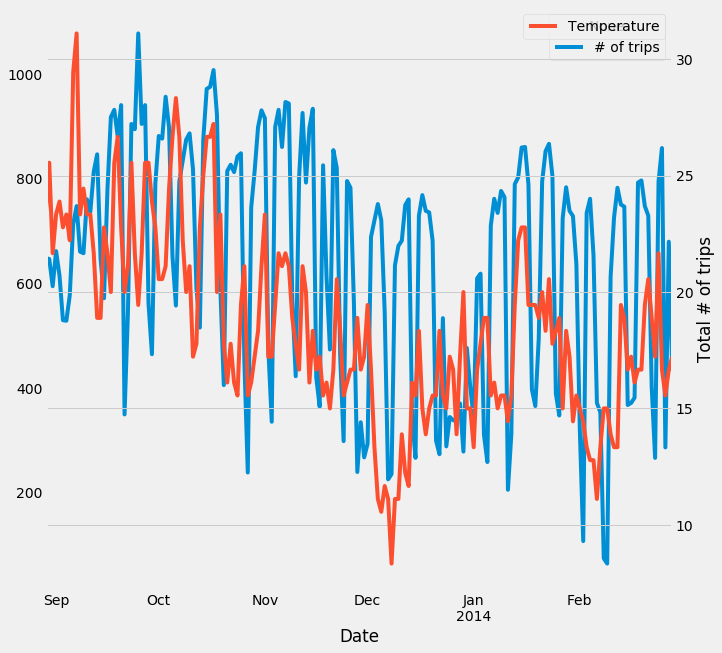

In [189]:
result_small.groupby('Date').size().plot(figsize=(10, 10), label='# of trips')
plt.legend()
result_small.groupby('Date').Max_Temperature_F.mean().plot(figsize=(10, 10),secondary_y=True,label='Temperature')
plt.legend()
plt.ylabel("Total # of trips")

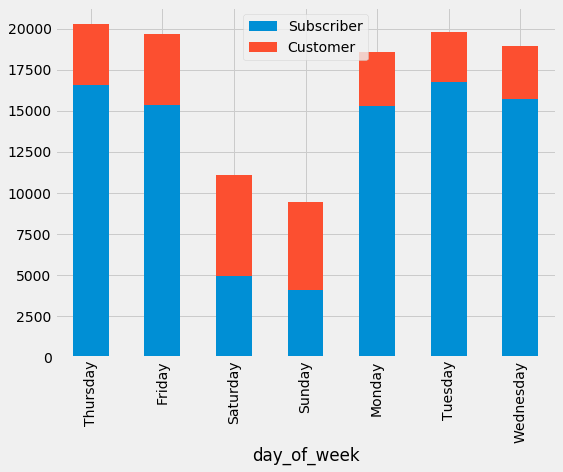

In [190]:
result_small.groupby(['subsc_type','day_of_week'],sort=False).date_time.count().unstack('subsc_type').plot(kind='bar',stacked=True,figsize=(8,6))
plt.legend(loc='best')

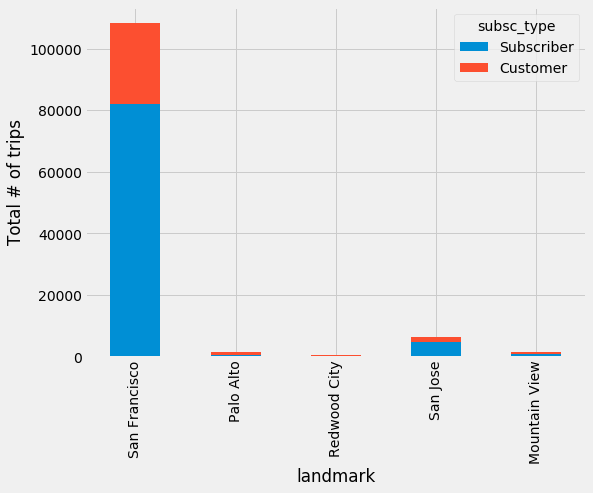

In [191]:
result_small.groupby(['subsc_type','landmark'],sort=False).date_time.count().unstack('subsc_type').plot(kind='bar',stacked=True,figsize=(8,6))
plt.ylabel("Total # of trips")

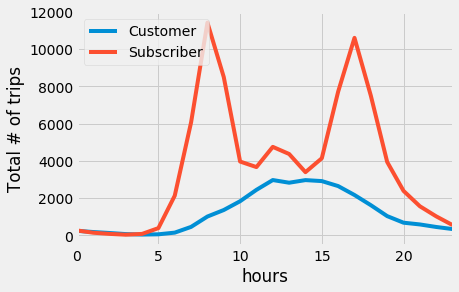

In [192]:
result_small.loc[:,'hours'] = result_small.date_time.dt.hour
result_small.groupby(['subsc_type','hours']).date_time.count().unstack('subsc_type').plot()
plt.ylabel("Total # of trips")
plt.legend(loc=2)

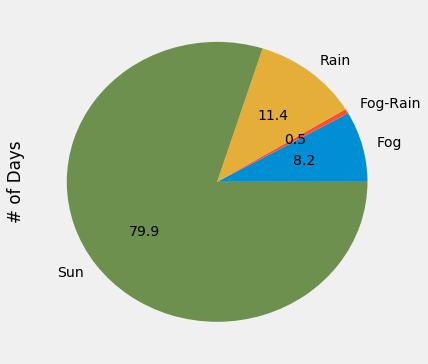

In [193]:
EvDa = result_small.groupby(['Events','Date']).size()
EvDa.groupby(level=0).size().plot.pie(autopct='%.1f', figsize=(6, 6))
plt.ylabel("# of Days")


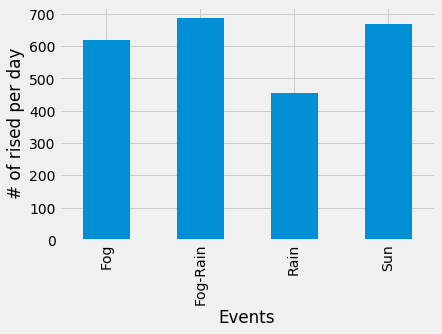

In [194]:
EvDa = result_small.groupby(['Events','Date']).size()
Days = EvDa.groupby(level=0).size()
Ev   = result_small.groupby('Events').size()
Ev.div(Days).plot.bar()
plt.ylabel("# of rised per day")
